In [1]:
#Import libraries

from qiskit import QuantumCircuit
from qiskit_ibm_runtime.fake_provider import FakeLagosV2 , FakePerth, FakeBelemV2, FakeValenciaV2, FakeRomeV2, FakeOslo
from qiskit.visualization import plot_circuit_layout, plot_coupling_map

# provider - N Qubit
#Lagos-7  Perth-7  Belem-5 Valencia-5  Roma-5 Oslo-7

from qiskit import transpile
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt
import math
from itertools import combinations

In [2]:
#Quantum Circuit
qc = QuantumCircuit( 5 ,2 )
qc.h(0)
qc.cx(0,1)
qc.h(1)
qc.cx(1,2)
qc.x(2)
qc.cx(2,3)
qc.measure( [2,3],[0,1] )
print(qc)


     ┌───┐                               
q_0: ┤ H ├──■────────────────────────────
     └───┘┌─┴─┐┌───┐                     
q_1: ─────┤ X ├┤ H ├──■──────────────────
          └───┘└───┘┌─┴─┐┌───┐     ┌─┐   
q_2: ───────────────┤ X ├┤ X ├──■──┤M├───
                    └───┘└───┘┌─┴─┐└╥┘┌─┐
q_3: ─────────────────────────┤ X ├─╫─┤M├
                              └───┘ ║ └╥┘
q_4: ───────────────────────────────╫──╫─
                                    ║  ║ 
c: 2/═══════════════════════════════╩══╩═
                                    0  1 


In [3]:
shots = 200
num_samples = 1000
measured_qubits = 2

Backend_list= {
    'Lagos'    : FakeLagosV2(),
    #'Perth'    : FakePerth(),
    #'Belem'    : FakeBelemV2(),
    'Valencia' : FakeValenciaV2(),
    #'Rome'     : FakeRomeV2(),
    #'Oslo'     : FakeOslo()
}

In [4]:
# Function for run our quantum circuit on a backend
 
def run_circuit(circuit, backend, shots, measured_qubits ):
    
# transpile the circuit for the backend
    transpiled_circuit = transpile(circuit, backend) 

# run the transpile circuit on the backend 
    job = backend.run(transpiled_circuit, shots = shots)

# get the result counts
    counts = job.result().get_counts()

# define all_possible_keys in order to convert natural number in range 2^(number of measured qubit) in binary number
    # exemple: measured_qubit = 2; [ 1,2,3,4] --> [00 , 01 , 10 , 11 ]
    all_possible_keys = [format(i, '0'+str(measured_qubits)+'b') for i in range(2**measured_qubits)]

# Let's normalize the counts in order to have values in range [0,1]. Additionally, let's add the keys with no counts, assigning them a value of 0
    for key in all_possible_keys:
        if key not in counts:
            counts[key] = 0.0
        counts[key] = counts[key]/shots
    sorted_counts = dict(sorted(counts.items()))
    return sorted_counts

In [5]:
# Function for create an array with counts get by 'run_circuit'

def make_counts_array( num_samples , circuit , backend, shots, measured_qubits):
    
# preallocate a matrix with dimention [num_samples] x [ 2^(measured_qubit) ]
    data = np.zeros((num_samples , 2**measured_qubits))
    
    for i in range( num_samples):
        
        # preallocate the array for the counts
        counts_array = np.zeros(2**measured_qubits)
        counts = run_circuit(circuit, backend, shots, measured_qubits)
        
        # fill the count_array
        for j, key in enumerate(sorted(counts.keys())):
            counts_array[j] = counts[key]
        data[i] = counts_array
    return data

In [6]:
# Function to create a dataset and a labels

def make_dataset(num_samples, circuit, backend1, backend2, shots, measured_qubits):
    
# preallocate a dataset with dimention [2num_samples] x [ 2^(measured_qubit) ]
    dataset = np.zeros((2*num_samples, 2**measured_qubits))
    
    # generate samples calling the function 'make_counts_array' using backend1 as input
    data1 = make_counts_array( num_samples, circuit, backend1, shots, measured_qubits)
    
    # generate samples calling the function 'make_counts_array' using backend1 as input
    data2 = make_counts_array( num_samples, circuit, backend2, shots, measured_qubits)

    # Concatenate data1 and data2
    dataset = np.concatenate([data1,data2])
    
    # create the labels: 0 for samples of backend1, 1 for samples of backend2
    labels = np.concatenate([np.zeros(num_samples), np.ones(num_samples)])
    
    # return the dataset and the labels
    return dataset, labels

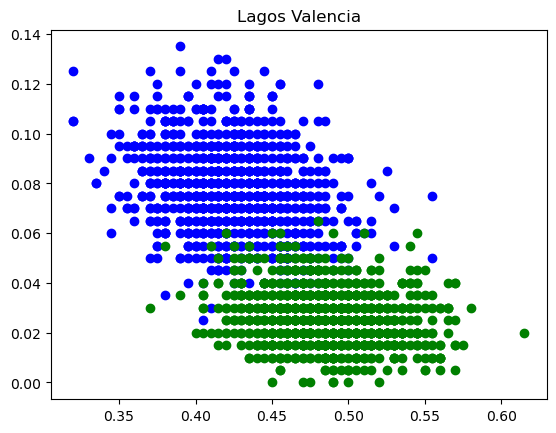

In [7]:
keys = list(Backend_list.keys())
for combination in combinations(keys,2):
    key1, key2 = combination
    file_name   = 'Dati/dataset_{}_x_{}'.format( key1 , key2)
    labels_name = 'Dati/labels_{}_x_{}'.format( key1 , key2)
    dataset, labels = make_dataset(num_samples, qc , Backend_list[key1], Backend_list[key2], shots, measured_qubits)
    np.save(file_name , dataset)
    np.save(labels_name, labels)
    plt.scatter(x=dataset[labels==0,0], y=dataset[labels==0,1],color='blue' )
    
    plt.scatter(x=dataset[labels==1,0], y=dataset[labels==1,1] ,color='green')
    plt.title(key1 + ' ' + key2)
    plt.savefig( "Grafici/{}_x_{}.png".format(key1,key2))